<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 6 &ndash; Introduction to Reinforcement Learning (Assignment)</h2>

<b>Student: Aral Cimcim

Student_ID: k11720457</b>

<b>Authors:</b> B. Schäfl, S. Lehner, J. Brandstetter, E. Kobler, M. Abbass, A. Schörgenhumer<br>
<b>Date:</b> 13-06-2023

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>

This notebook is designed to run from start to finish. There are different tasks (displayed in <span style="color:rgb(248,138,36)">orange boxes</span>) which require your contribution (in form of code, plain text, ...). Most/All of the supplied functions are imported from the file <code>u6_utils.py</code> which can be seen and treated as a black box. However, for further understanding, you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u6_utils.py</code> need to be installed.

In [1]:
# Import pre-defined utilities specific to this notebook.
import u6_utils as u6

# Import additional utilities needed in this notebook.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import time
import gymnasium as gym

from IPython import display
from typing import Tuple

# Set default plotting style.
sns.set()

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u6.setup_jupyter()

# Check minimum versions.
u6.check_module_versions()

Installed Python version: 3.7 (✗)
Installed numpy version: 1.21.6 (✓)
Installed pandas version: 1.3.5 (✓)
Installed PyTorch version: 1.7.0 (✓)
Installed matplotlib version: 3.5.3 (✓)
Installed seaborn version: 0.12.2 (✓)
Installed gym version: 0.28.1 (✓)


<h2>Dissection of an Environment</h2>
<p>All exercises in this assignment are referring to the <i>FrozenLake</i> environment as described <a href="https://gymnasium.farama.org/environments/toy_text/frozen_lake/">here</a>.
<center>
    <cite>Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly <span style="color:rgb(0,255,0)">frozen</span>, but there are a few <span style="color:rgb(255,0,0)">holes</span> where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the <span style="color:rgb(255,0,255)">disc</span>. However, the ice is slippery, so you won't always move in the direction you intend.</cite>
    </center></p>


<p>There are <i>four</i> types of surfaces described in this environment:
<ul>
    <li><code>S</code> $\rightarrow$ starting point (<span style="color:rgb(0,255,0)"><i>safe</i></span>)</li>
    <li><code>F</code> $\rightarrow$ frozen surface (<span style="color:rgb(0,255,0)"><i>safe</i></span>)</li>
    <li><code>H</code> $\rightarrow$ hole (<span style="color:rgb(255,0,0)"><i>fall to your doom</i></span>)</li>
    <li><code>G</code> $\rightarrow$ goal (<span style="color:rgb(255,0,255)"><i>frisbee location</i></span>)</li>
</ul>

In [34]:
# Utility function for creating a default FrozenLake environment.
def FrozenLakeEnv(slippery: bool = False, max_episode_steps: int = 100_000) -> gym.Env:
    return gym.make('FrozenLake-v1', desc=None, map_name='8x8', is_slippery=slippery, max_episode_steps=max_episode_steps, render_mode='ansi')

<div class="alert alert-warning">
    <b>Exercise 1. [10 Points]</b>
    <ul>
        <li>Create a <code>FrozenLakeEnv</code> with <code>slippery = False</code> and set the seed to $23$. Use this environment in the subsequent tasks if not specified otherwise.</li>
        <li>Gather and print the amount of different <i>actions</i> as well as <i>states</i> of the <code>FrozenLakeEnv</code> instance. Discuss the results.</li>
        <li>Display the <i>reward table entry</i> for the current state. Discuss the different elements of the resulting dictionary.</li>
        <li>Perform $25$ different random actions using <code>env_lake.action_space.sample()</code>. Print the action number, state (observation), reward, whether the episode is done (either by being terminated or being truncted), and render the corresponding environment. Hint: If the episode is done, reset the environment or you are stuck.</li>
    </ul>
</div>

In [33]:
# Create env with slippery = False.
env_frozen_lake = FrozenLakeEnv(slippery = False)

# Set seed to 23.
u6.set_environment_seed(env_frozen_lake, 23)

# Print the environment.
print(env_frozen_lake.render())

# Print the num actions & num states.
num_actions = env_frozen_lake.action_space.n
num_states = env_frozen_lake.observation_space.n

# Print the actions & states.
print(f'The Frozen Lake Environment comprises of {num_actions} actions and {num_states} states.')


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

The Frozen Lake Environment comprises of 4 actions and 64 states.


In [4]:
# Display the reward table for the current state.
reward_table_current = env_frozen_lake.s
env_frozen_lake.P[reward_table_current]

{0: [(1.0, 0, 0.0, False)],
 1: [(1.0, 8, 0.0, False)],
 2: [(1.0, 1, 0.0, False)],
 3: [(1.0, 0, 0.0, False)]}

When slippery = False, the transition probability = 1, 0.0 are the rewards (reaching the goal gets a reward of +1), bool is for whether the goal is reached.

<p>There are 4 actions in total:
<table style="text-align:center;vertical-align:middle">
    <tr>
        <th style="width:75px">Action</th>
        <th style="width:150px">Description</th>
    </tr>
    <tr>
        <td>$0$</td>
        <td>move <i>left</i> (&#8592;)</td>
    </tr>
    <tr>
        <td>$1$</td>
        <td>move <i>down</i> (&#8595;)</td>
    </tr>
    <tr>
        <td>$2$</td>
        <td>move <i>right</i> (&#8594;)</td>
    </tr>
    <tr>
        <td>$3$</td>
        <td>move <i>up</i> (&#8593;)</td>
    </tr>
    <tr>
</table>

<ul>
    <li>4 possible actions</li>
    <li>10 holes and 52 frozen locations</li>
    <li>64 different states on the grid</li>
    <li>1 goal state 'G' at location 64</li>
</ul>

$4 \times 64 = 256$ different values.</p>

In [39]:
# Randomly perform 25 actions in the environment.
num_steps, final_reward, num_penalties = 0, 0, 0

done = False

# Reset the environment.
env_frozen_lake.reset()

while not done:
    current_action = env_frozen_lake.action_space.sample()
    current_state, current_reward, terminated, truncated, _ = env_frozen_lake.step(current_action)
    done = terminated or truncated

    # Update counter for inflicted penalties & rewards.
    # Reward is +1 if goal is reached, 0 otherwise (according to the documentation)
    final_reward += current_reward
    if current_reward == 0:
        num_penalties += 1
    num_steps += 1

    # End at 25 steps.
    if num_steps == 25:
        done = True
    
    display.clear_output(wait=True)
    print(env_frozen_lake.render())
    print(f'Num of Steps: {num_steps}'
            f'\nState ID: {current_state}'
            f'\nAction ID: {current_action}'
            f'\nFinal Reward: {final_reward}'
            f'\nDone: {done}')
    time.sleep(0.01)


  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Num of Steps: 25
State ID: 32
Action ID: 1
Final Reward: 0.0
Done: True


<h2>Tackling the Environment with Random Exploration</h2>
<p>In the exercise, we talked about solving this kind of tasks in a na&#xEF;ve way by simply applying <i>brute force</i>: using <i>random search</i>. So far, we analyzed the <i>action</i> as well as the <i>state space</i> and came to the conclusion that such an approach is feasible. Here is the outline of such an approach:
<ul>
    <li><code>I</code> $\rightarrow$ choose a random <i>action</i> with respect to the <i>current</i> state.</li>
    <li><code>II</code> $\rightarrow$ execute previously chosen <i>action</i> and transition into a <i>new</i> state.</li>
    <li><code>III</code> $\rightarrow$ if the episode is finished but the goal is not reached, <i>reset</i> the <i>environment</i>.</li>
</ul>

This procedure is repeated as long as the task is not solved or a defined <i>maximum number of steps</i> is reached, whatever triggers first (<code>IV</code>). Adapt the function <code>apply_random_search</code> as discussed during the exercise. Mark the corresponding sections of the code using <code>I</code>, <code>II</code>, <code>III</code> and <code>IV</code>. Note that our <i>random search</i> is <i>not</i> guaranteed to find  the solution of a task in <i>finite time</i>, hence an upper bound on the <i>runtime</i> is often applied as a safety net (in our case the <i>maximum number of steps</i>).</p>

<div class="alert alert-warning">
    <b>Exercise 2.1 [10 Points]</b>
    <ul>
        <li>Implement the <i>random search</i> algorithm as outlined above (equivalently to the one discussed during the exercise).</li>
        <li>Apply your random search implementation on a freshly $23$-seeded <code>FrozenLakeEnv</code> instance, with an animation delay of $0.01$ and a maximum number of steps of $750$.</li>
        <li>Was the goal reached, how many steps were taken and how often did an involuntary dive happen?</li>
        <li>Repeat the experiment and find parameters (random seed, maximum number of steps) that lead to a successful run (you do not need to animate this second experiment).</li>
    </ul>
</div>

In [108]:
def apply_random_search(environment: gym.Env, animate: bool = False,
                        delay: float = 0.01, upper_bound: int = 1000) -> Tuple[int, int, int, int]:
    """
    Solve specified environment by applying random search.
    
    :param environment: the environment on which to apply random search
    :param animate: animate the random search process
    :param delay: the minimum delay in milliseconds between each rendered frame (ignored if not animated)
    :return: amount of steps performed, penalties inflicted and final reward
    """

    num_steps, num_dives, num_penalties, final_reward = 0, 0, 0, 0
    
    # <III>: if the episode is finished but the goal is not reached, reset the environment.
    done = False
    environment.reset()

    while not done:
        # <I>: select a random action.
        current_action = environment.action_space.sample()
        
        # <II>: perform the selected action.
        current_state, current_reward, terminated, truncated, _ = environment.step(current_action)
        done = terminated or truncated
        
        # update the counter for inflicted penalties & rewards.
        # add a penalty for every F with 0 rewards.
        final_reward += current_reward
        if current_reward == 0:
            num_penalties += 1
        num_steps += 1
        
        # <IV>: Reset the env. if the agent falls into hole.
        if done and current_reward == 0:
            done = False
            environment.reset()
            # Get the num of dives after each fall.
            num_dives += 1

        # <IV>: If the agent reaches the goal, current reward = 1.
        if done and current_reward == 1:
            final_reward == 1

        # <IV>: Return done at upper bound.
        if num_steps == upper_bound:
            done = True
        
        if animate:
            display.clear_output(wait=True)
            print(environment.render())
            print(f'Num of Steps: {num_steps}'
                  f'\nNum of Involuntary Dives: {num_dives}'
                  f'\nNum of Penalties: {num_penalties}'
                  f'\nState ID: {current_state}'
                  f'\nAction ID: {current_action}'
                  f'\nFinal Reward: {final_reward}'
                  f'\nDone: {done}')
            time.sleep(delay)

    return num_steps, num_dives, num_penalties, final_reward

In [109]:
# Create new instance of the env.
env_frozen_lake = FrozenLakeEnv(slippery=False)

# Set seed to 23.
u6.set_environment_seed(env_frozen_lake, 23)

# Perform random search.
apply_random_search(env_frozen_lake, animate=True, delay=0.01, upper_bound=750)

  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Num of Steps: 750
Num of Involuntary Dives: 22
Num of Penalties: 750
State ID: 15
Action ID: 3
Final Reward: 0.0
Done: True


(750, 22, 750, 0.0)

For upper bound 750, the agent does not reach the goal with random exploration.
750 steps were taken with 22 involuntary dives.

In [42]:
# Set seed to 23.
u6.set_environment_seed(env_frozen_lake, 23)

# Perform random search.
apply_random_search(env_frozen_lake, animate=False, delay=0.01, upper_bound=None)

(8916, 288, 8915, 1.0)

In [43]:
# Set seed to 0.
u6.set_environment_seed(env_frozen_lake, 0)

# Perform random search.
apply_random_search(env_frozen_lake, animate=False, delay=0.01, upper_bound=None)

(91, 1, 90, 1.0)

In [44]:
# Set seed to 30.
u6.set_environment_seed(env_frozen_lake, 30)

# Perform random search.
apply_random_search(env_frozen_lake, animate=False, delay=0.01, upper_bound=None)

(149, 5, 148, 1.0)

At seed set to 23, the agent reaches the goal state after 8916 steps (without setting an upper bound) and takes 288 involuntary dives.

At seed set to 0, the goal state is reached after 91 steps with 1 involuntary dive (without upper bound).

At seed set to 30, the goal state is reached after 149 steps with 5 involuntary dives. (without upper bound).

<p>To drill down on the drawbacks of plain <i>random search</i>, we are designing the following experimental setup (<i>Hint</i>: it is actually the same experimental setup as already discussed during the exercise, so you might orient yourself on the implementation presented during class):
<ul>
    <li>Repeat the previous <i>random search</i> procedure a specified amount of times.</li>
    <li>Aggregate the results of each run for later analysis.</li>
    <li>Visualize the aggregated results using <i>box-</i> and <i>strip-plots</i> (or <i>swarm-plots</i>).</li>
</ul>
Once again, we are setting the <i>random seed</i>, but take care of setting it <i>outside</i> the loop, otherwise the same result is reported with each iteration (and an aggregation of the results would not give us any more insights).</p>

In [45]:
env_frozen_lake_swarm = FrozenLakeEnv(slippery = False)
u6.set_environment_seed(environment=env_frozen_lake_swarm, seed=23)
num_steps_total, num_involuntary_dives_total, num_penalties_total, final_reward_total = [], [], [], []
num_repetitions = 750

# Collect information over multiple repetitions.
for repetition in range(num_repetitions):
    env_frozen_lake_swarm.reset()
    num_steps, num_dives, num_penalties, final_reward = apply_random_search(environment=env_frozen_lake_swarm)
    num_steps_total.append(num_steps)
    num_involuntary_dives_total.append(num_dives)
    num_penalties_total.append(num_penalties)
    final_reward_total.append(final_reward)

# Combine collected information to a data frame for further downstream analysis.
collected_experiment_info = pd.DataFrame({
    'Steps performed': num_steps_total,
    'Penalties inflicted': num_penalties_total,
    'Final reward': final_reward_total,
    'Number of Involuntary Dives': num_involuntary_dives_total
})

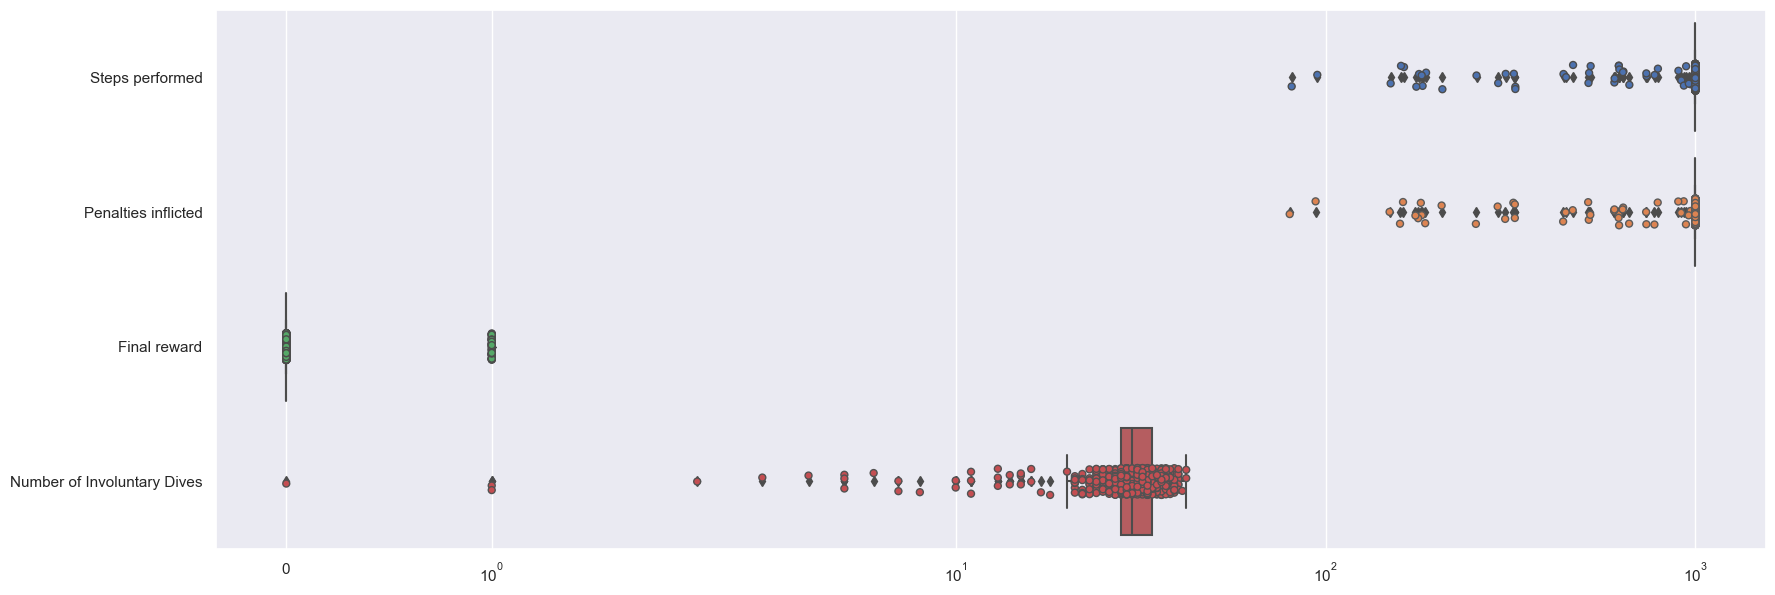

In [46]:
# Visualize aggregated results of the random search procedure.
fig, ax = plt.subplots(figsize=(20, 7))
ax.set_xscale('symlog')
sns.boxplot(data=collected_experiment_info, ax=ax, orient='h')
sns.stripplot(data=collected_experiment_info, ax=ax, orient='h', linewidth=1)
plt.show()

<div class="alert alert-warning">
    <b>Exercise 2.2 [10 Points]</b>
    <ul>
        <li>Conduct a <i>random search experiment</i> as outlined above, using $100$ repetitions and the random seed set to $23$. Set the maximum number of steps to $10,000$.</li>
        <li>Create a plot showing the results and interpret the visualization.</li>
        <li>In comparison with the <code>Taxi</code> environment, what might be the problem with <code>FrozenLakeEnv</code> w.r.t. random exploration?</li>
    </ul>
</div>

In [47]:
env_frozen_lake_swarm2 = FrozenLakeEnv(slippery = False)
u6.set_environment_seed(environment=env_frozen_lake_swarm2, seed=23)
num_steps_total, num_involuntary_dives_total, num_penalties_total, final_reward_total = [], [], [], []
num_repetitions = 100

# Collect information over multiple repetitions.
for repetition in range(num_repetitions):
    env_frozen_lake_swarm2.reset()
    num_steps, num_dives, num_penalties, final_reward = apply_random_search(environment=env_frozen_lake_swarm2, upper_bound=10000)
    num_steps_total.append(num_steps)
    num_involuntary_dives_total.append(num_dives)
    num_penalties_total.append(num_penalties)
    final_reward_total.append(final_reward)

# Combine collected information to a data frame for further downstream analysis.
collected_experiment_info = pd.DataFrame({
    'Steps performed': num_steps_total,
    'Penalties inflicted': num_penalties_total,
    'Final reward': final_reward_total,
    'Number of Involuntary Dives': num_involuntary_dives_total
})

The problem with random exploration is that in this environment the agent can fall into holes and restart again. Finding an optimal policy would take longer with more penalties using random exploration. The agent might get lucky and reach the goal, but there is no guarantee.

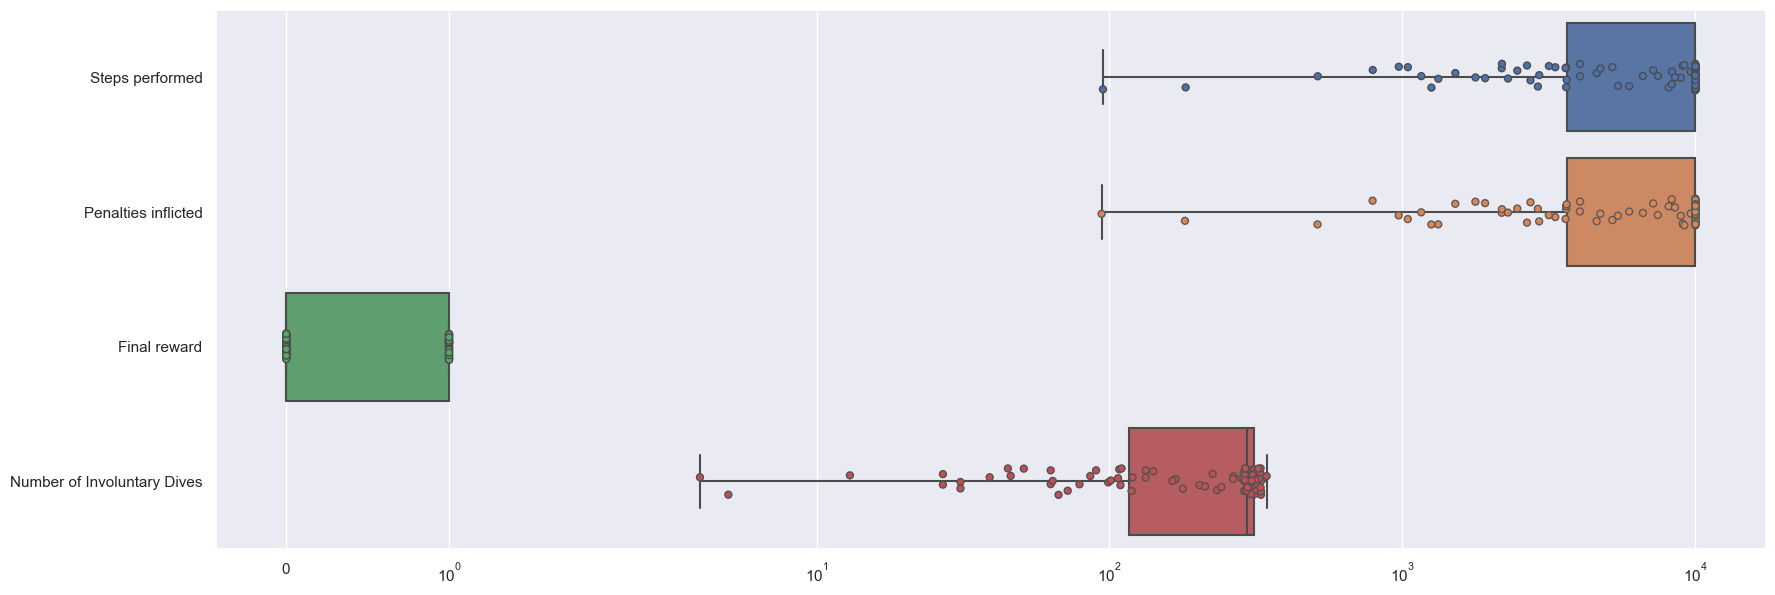

In [48]:
# Visualize aggregated results of the random search procedure.
fig, ax = plt.subplots(figsize=(20, 7))
ax.set_xscale('symlog')
sns.boxplot(data=collected_experiment_info, ax=ax, orient='h')
sns.stripplot(data=collected_experiment_info, ax=ax, orient='h', linewidth=1)
plt.show()

The final reward is binary as specified by the gym documentation with a max. value of 1.

The number of involuntary dives ranges from 100 to around 500.

Since each 'H' location increases the penalty by 1, the steps performed and penalties inflicted have similar convergence.

From the graph, it could be stated that random exploration is suboptimal for this environment.

Overall, with random search, the agent demonstrates trial-error learning.

<h2>Tackling the Environment with $Q$-Learning</h2>
<p>In a simplified version of $Q$-learning, the <b>$\boldsymbol{Q}$-value</b>
\begin{equation}
    Q(s,a)
\end{equation}</p>

<p>is the expected future reward of being in state $s$ and taking action $a$. Intuitively, if the $Q$-values are learned correctly, a good policy would be to take the action which maximizes the expected future reward. This is what $Q$-learning is doing. $Q$-learning lets the agent <b>use the environment's rewards to learn</b>, over time, the best action to take in a given state. $Q$-values are initialized to an arbitrary value, and as the agent exposes itself to the environment and receives different rewards by executing different actions, the $Q$-values are updated using the equation:
\begin{equation}
    Q(s_t,a_t) \leftarrow (1 - \alpha) \cdot Q(s_t,a_t) + \alpha \cdot \left( r_t + \gamma \max_{a_{t+1}} Q(s_{t+1}, a_{t+1})\right)
\end{equation}</p>

<p>We are assigning $\leftarrow$, or updating, the $Q$-value of the agent's current state and action, denoted as $Q(s_t,a_t)$ with $\alpha$ as the learning rate, i.e the extent to which our $Q$-values are being updated in every iteration.</p>

<p>The <b>$\boldsymbol{Q}$-table</b> is a matrix where we have a row for every state and a column for every action: $64$ and $4$, respectively, when referring to the current <i>FrozenLake</i> example. It's first initialized to $0$, and then values are updated during training.</p>

<p>Previously, we talked about solving this task in a na&#xEF;ve way by simply applying <i>brute force</i> using <i>random search</i>. This time, we want to apply a more sophisticated algorithm, namely $Q$-learning:
<ul>
    <li><code>I</code> $\rightarrow$ Choose action $a_t$.
    <li><code>II</code> $\rightarrow$ Go from state $s_t$ to state $s_{t+1}$ by taking action $a_{t}$.
    <li><code>III</code> $\rightarrow$ For all possible $Q$-values from the state $s_{t+1}$, select the highest.
    <li><code>IV</code> $\rightarrow$ Update $Q$-table values using the equation from above.
    <li><code>V</code> $\rightarrow$ Set the next state as the current state and go back to <code>I</code> until a final state is reached (end of episode).
</ul>

This procedure is repeated for as many episodes as specified (<code>VI</code>).</p>

<div class="alert alert-warning">
    The following code snippet is taken from the accompanying exercise notebook. You do not need to modify it for this assignment.
</div>

In [50]:
def visualize_q_table(q_table: np.ndarray, title: str = '') -> None:

    """
    Visualize Q-table using a heatmap plot.
    :param q_table: Q-table to visualize
    """

    fig, ax = plt.subplots(figsize=(20, 7))
    sns.heatmap(data=q_table, ax=ax)
    ax.set(xlabel='Action', ylabel='State', title=title)
    display.clear_output(wait=True)
    display.display(fig)
    plt.close(fig=fig)


def apply_q_learning(environment: gym.Env, num_episodes: int = 1000, alpha: float = 0.1, gamma: float = 1.0, animate: bool = False, delay_steps: int = 100) -> np.ndarray:

    """
    Solve specified environment by applying Q-learning.
    :param environment: the environment on which to apply Q-learning
    :param num_episodes: the total amount of episodes used to adapt the Q-table
    :param alpha: the learning rate to be applied by Q-learning
    :param gamma: the discount factor of future rewards
    :param animate: animate the Q-learning process
    :param delay_steps: the steps between each Q-table visualization (ignored if not animated)
    :return: adapted Q-table
    """
    
    q_table = np.zeros(shape=(environment.observation_space.n, environment.action_space.n))
    
    # <VI>: repeat Q-learning as long as the total amount of episodes is not yet reached.
    for episode in range(num_episodes):
        state, _ = environment.reset()
        
        done = False
        while not done:
            
            # <I>: choose next action according to current Q-table.
            action = np.argmax(q_table[state])
            
            # <II>: go from the current state to the next by applying chosen action.
            next_state, reward, terminated, truncated, _ = environment.step(action)
            done = terminated or truncated
            
            # <III>: from all possible Q-values w.r.t. the new state, select the highest.
            next_max = np.max(q_table[next_state])
            
            # <IV>: update the Q-table accordingly.
            old_value = q_table[state, action]
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value
            
            # <V>: update the next step with the current one.
            state = next_state
        
        # Optionally visualize the current Q-table.
        if animate and any(((episode + 1) % delay_steps == 0, (episode + 1) == num_episodes)):
            visualize_q_table(q_table=q_table, title=f'Episode {episode + 1}')
    
    return q_table

<div class="alert alert-warning">
    <b>Exercise 3.1 [10 Points]</b>
    <ul>
        <li>Implement <i>$Q$-learning</i> as outlined above (equivalently to the one discussed during the exercise).</li>
        <li>Apply $Q$-learning on a freshly $23$-seeded <code>FrozenLakeEnv</code> instance for $500$ episodes, with $10$ delay steps, a discount factor $\gamma=0.99$ and $\alpha=0.1$. Important: Make sure that you create a new <code>FrozenLakeEnv</code> instance where <code>max_episode_steps</code> is set to $100$ (only in this exercise), since otherwise, the code execution might take very long.</li>
        <li>Interpret the visualization of the resulting $Q$-table. What do you observe? Why do you observe this effect?</li>
    </ul>
</div>

In [51]:
# Create a fresh instance of the env.
env_frozen_lake_q = FrozenLakeEnv(slippery = False, max_episode_steps = 100)

# Set seed to 23.
u6.set_environment_seed(env_frozen_lake_q, 23)

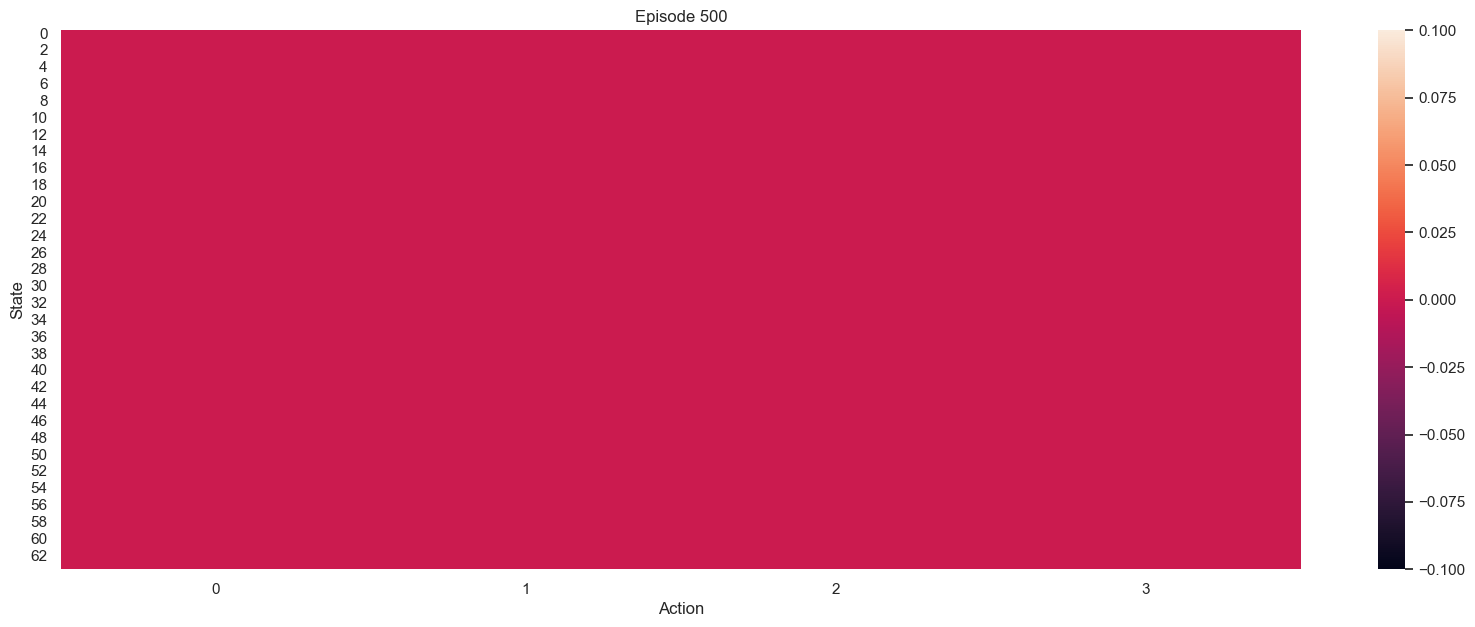

In [61]:
q_table = apply_q_learning(
    environment=env_frozen_lake_q,
    num_episodes=500,
    alpha=0.1,
    gamma=0.99,
    animate=True,
    delay_steps=10
)

The q values are all 0.

The q table is initially 0, for the next q value: (1 - 0.1) * 0 + 0.1 * (1 + 0.99 * 0) = 0.1

With this algorithm, regardless of alpha and gamma, the agent will always get the same value and not learn anything.

<p>Very likely, the $Q$-table of the previous experiment looked a little bit odd. Try to add exploration to your algorithm by adapting your $Q$-learning implementation:
    <ul>
        <li>Get a random uniform number between $0$ and $1$.</li>
        <li>If the number is $< 0.1$, choose your action as usual (according to current Q-table).</li>
        <li>Otherwise, sample a random action.</li>
    </ul>
</p>

<div class="alert alert-warning">
    <b>Exercise 3.2 [20 Points]</b>
    <ul>
        <li>Modify the <i>$Q$-learning</i> implementation from the previous tasks as outlined above (mark the corresponding code sections).</li>
        <li>Apply $Q$-learning on a freshly $23$-seeded <code>FrozenLakeEnv</code> instance for $40,000$ episodes, with $1,000$ delay steps, discount factor $\gamma=0.99$ and $\alpha=0.1$.</li>
        <li>Interpret the visualization of the resulting $Q$-table. What do you observe (compare with the previous visualization)?</li>
        <li>Use this $Q$-learning strategy to also tackle the <code>FrozenLakeEnv</code> with <code>slippery = True</code>. Compare both $Q$-tables and discuss the differences.</li>
    </ul>
</div>

In [65]:
def apply_q_learning_adapted(environment: gym.Env, num_episodes: int = 1000, alpha: float = 0.1, gamma: float = 1.0, animate: bool = False, delay_steps: int = 100) -> np.ndarray:
    
    """
    Solve specified environment by applying Q-learning.
    
    :param environment: the environment on which to apply Q-learning
    :param num_episodes: the total amount of episodes used to adapt the Q-table
    :param alpha: the learning rate to be applied by Q-learning
    :param gamma: the discount factor of future rewards
    :param animate: animate the Q-learning process
    :param delay_steps: the steps between each Q-table visualization (ignored if not animated)
    :return: adapted Q-table
    """

    # Adapted for exploration, see <I> below.
    q_table = np.zeros(shape=(environment.observation_space.n, environment.action_space.n))

    # <VI>: repeat Q-learning as long as the total amount of episodes is not yet reached.
    for episode in range(num_episodes):
        state, _ = environment.reset()

        done = False
        while not done:

            # <I>: choose next action according to current Q-table.
            # Exploration: get rand val between 0 and 1, if val < 1 take argmax as usual, else perform rand action.
            if np.random.uniform(0, 1) < 0.1:
                action = np.argmax(q_table[state])
            else:
                action = np.random.randint(0, 4)

            # <II>: go from the current state to the next by applying chosen action.
            next_state, reward, terminated, truncated, _ = environment.step(action)
            done = terminated or truncated

            # <III>: from all possible Q-values w.r.t. the new state, select the highest.
            next_max = np.max(q_table[next_state])

            # <IV>: update the Q-table accordingly.
            old_value = q_table[state, action]
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            # <V>: update the next step with the current one.
            state = next_state

        # Optionally visualize the current Q-table.
        if animate and any(((episode + 1) % delay_steps == 0, (episode + 1) == num_episodes)):
            visualize_q_table(q_table=q_table, title=f'Episode {episode + 1}')

    return q_table

In [66]:
# Create a fresh instance of the env. (slippery = False)
env_frozen_lake_q2 = FrozenLakeEnv(slippery = False)

# Set seed to 23.
u6.set_environment_seed(env_frozen_lake_q2, 23)

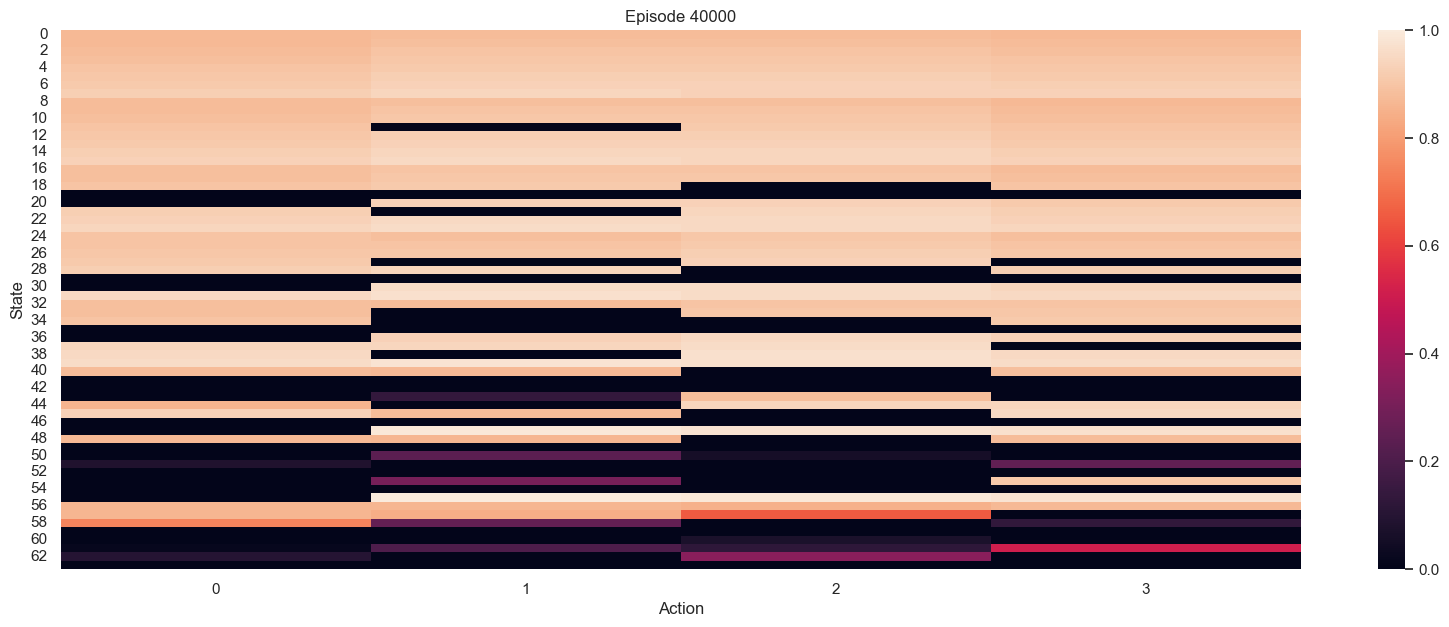

In [67]:
q_table_adapted_2 = apply_q_learning_adapted(
    environment=env_frozen_lake_q2,
    num_episodes=40000,
    alpha=0.1,
    gamma=0.99,
    animate=True,
    delay_steps=1000
)

For each state and action, there is a corresponding q value.

For some states & actions, the q values are 0 as expected.

The range of the values is between 0 and 1 with increased randomness generated by the agent.

In [77]:
# Create a fresh instance of the env. (slippery = True)
env_frozen_lake_q3 = FrozenLakeEnv(slippery = True)

# Set seed to 23.
u6.set_environment_seed(env_frozen_lake_q3, 23)

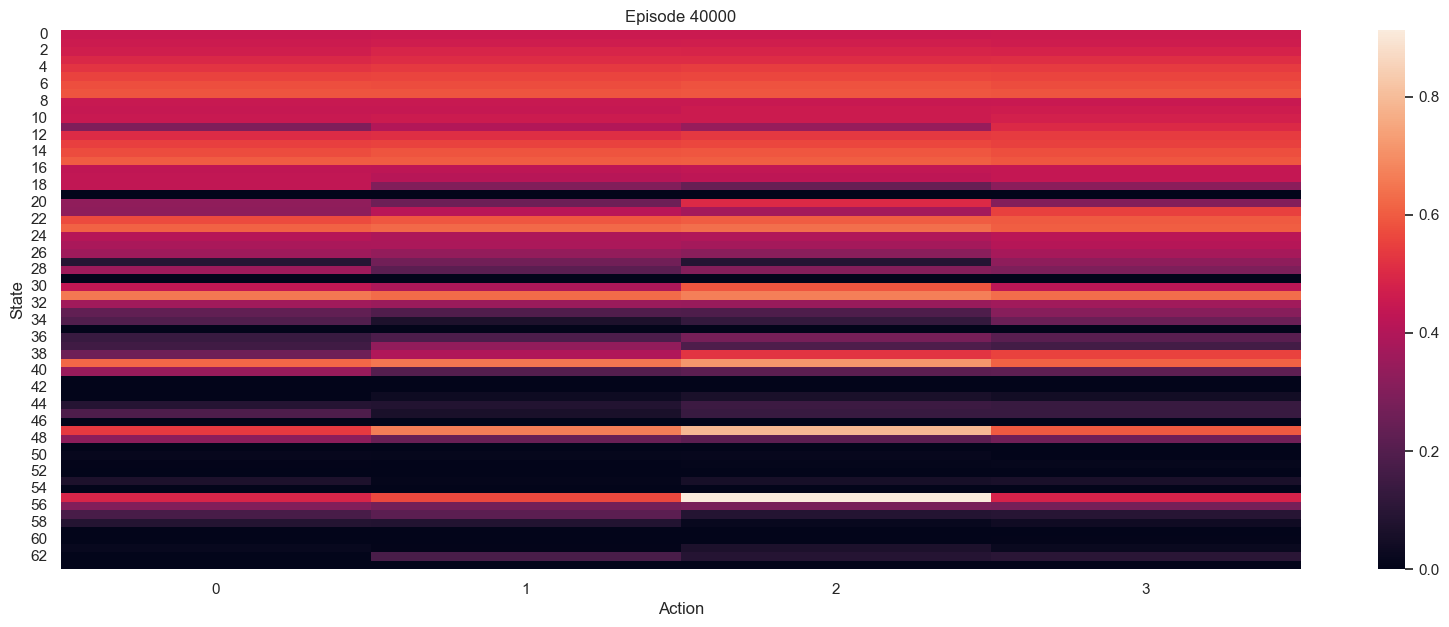

In [78]:
q_table_adapted_3 = apply_q_learning_adapted(
    environment=env_frozen_lake_q3,
    num_episodes=40000,
    alpha=0.1,
    gamma=0.99,
    animate=True,
    delay_steps=1000
)

With slippery = True, the environment transition probabilities change to 1/3, as indicated with the dark purple color, the transition of states are not just determined by the selected action.

There is a change in the mechanics of the environment from deterministic to stochastic.

<div class="alert alert-warning">
    <b>Exercise 3.3 [15 Points]</b>
    <ul>
        <li>Implement a function for applying a pre-trained $Q$-table on a <code>FrozenLakeEnv</code> instance (like discussed during class).</li>
        <li>For both <code>FrozenLakeEnv</code> instances (with <code>slippery = False</code> and <code>slippery = True</code>), conduct a guided search using the corresponding $Q$-table on a freshly $23$-seeded instance, with an animation delay of $0.1$.</li>
        <li>Answer the following question for both settings: How many steps are necessary to reach the goal at least once and how often did an involuntary dive happen?</li>
        <li>Compare the corresponding policies of each $Q$-table. Which property of the environment is exploited in the slippery policy to avoid involuntary dives?</li>
    </ul>
</div>

In [202]:
def apply_q_table(environment: gym.Env, q_table: np.ndarray, animate: bool = False, delay: float = 0.01) -> Tuple[int, int, int]:

    """
    Solve specified environment by applying specified Q-table.
    
    :param environment: the environment on which to apply Q-table guided search
    :param q_table: the Q-table used during Q-table guided search
    :param animate: animate the Q-table guided search process
    :param delay: the minimum delay in milliseconds between each rendered frame (ignored if not animated)
    :return: amount of steps performed, penalties inflicted and final reward
    """
    
    num_steps, num_dives, num_penalties, final_reward = 0, 0, 0, 0
    
    # <III>: repeat Q-table guided search procedure as long as the episode is still ongoing.
    done = False
    environment.reset()
    while not done:
        
        # <I>: choose action according to the Q-table with respect to the current state.
        current_action = np.argmax(q_table[environment.s])
        
        # <II>: execute previously chosen action and transition into a new state.
        current_state, current_reward, terminated, truncated, _ = environment.step(current_action)
        done = terminated or truncated
        
        # Update counter for inflicted penalties.
        final_reward += current_reward
        if current_reward == 0:
            num_penalties += 1
        num_steps += 1

        # <IV>: Reset the env if the agent falls into a hole.
        if done and current_reward == 0:
            done = False
            environment.reset()
            # Get the num of dives after each fall.
            num_dives += 1

        # Optionally display current state.
        if animate:
            display.clear_output(wait=True)
            print(environment.render())
            print(f'Step No.: {num_steps}'
                  f'\nNum of Involuntary Dives: {num_dives}'
                  f'\nNum of Penalties: {num_penalties}'
                  f'\nState ID: {current_state}'
                  f'\nAction ID: {current_action}'
                  f'\nFinal Reward: {final_reward}'
                  f'\nDone: {done}')
            time.sleep(delay)
    
    return num_steps, num_dives, num_penalties, final_reward

In [203]:
# slippery = False
u6.set_environment_seed(environment=env_frozen_lake_q2, seed=23)

num_steps, num_dives, num_penalties, final_reward = apply_q_table(
    environment=env_frozen_lake_q2,
    q_table=q_table_adapted_2,
    animate=True,
    delay=0.1)

  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Step No.: 14
Num of Involuntary Dives: 0
Num of Penalties: 13
State ID: 63
Action ID: 1
Final Reward: 1.0
Done: True


In [204]:
# slippery = True
u6.set_environment_seed(environment=env_frozen_lake_q3, seed=23)

num_steps, num_dives, num_penalties, final_reward = apply_q_table(
    environment=env_frozen_lake_q3,
    q_table=q_table_adapted_3,
    animate=True,
    delay=0.1)

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Step No.: 416
Num of Involuntary Dives: 0
Num of Penalties: 415
State ID: 63
Action ID: 2
Final Reward: 1.0
Done: True


In slippery = False, the agent can reach the goal after 14 steps, with 13 penalties, without falling in the hole.

In slippery = True, the agent can reach the goal after 416 steps, with 415 penalties, without falling in the hole.

In either case, the agent does not fall in a hole, for the slippery = True case it just takes the agent longer to reach the goal.

The transition probability is 0.3 in the slippery = True case, it seems that the agent does not intend to go in the direction but the increased randomness in the environment makes the agent slide to the upper right and keep sliding down until the goal is reached.

<div class="alert alert-warning">
    <b>Exercise 3.4 [10 Points]</b>
    <ul>
        <li>Conduct a <i>$Q$-table guided search experiment</i> on the non-slippery environment, as outlined previously, using $100$ repetitions and the random seed set to $23$.</li>
        <li>Create a plot showing the results and interpret the visualization.</li>
        <li>In comparison with the <i>random search</i> experiment, how does the $Q$-table guided search perform? Discuss the results.</li>
    </ul>
</div>

In [205]:
u6.set_environment_seed(environment=env_frozen_lake_q2, seed=23)
num_steps_total, num_involuntary_dives_total, num_penalties_total, final_reward_total = [], [], [], []
num_repetitions = 100

# Collect information over multiple repetitions.
for repetition in range(num_repetitions):
    env_frozen_lake_q2.reset()
    num_steps, num_dives, num_penalties, final_reward = apply_q_table(environment=env_frozen_lake_q2, q_table=q_table_adapted_2)
    num_steps_total.append(num_steps)
    num_involuntary_dives_total.append(num_dives)
    num_penalties_total.append(num_penalties)
    final_reward_total.append(final_reward)

# Combine collected information to a data frame for further downstream analysis.
collected_experiment_info = pd.DataFrame({
    'Steps performed': num_steps_total,
    'Penalties inflicted': num_penalties_total,
    'Final reward': final_reward_total,
    'Number of Involuntary Dives': num_involuntary_dives_total
})

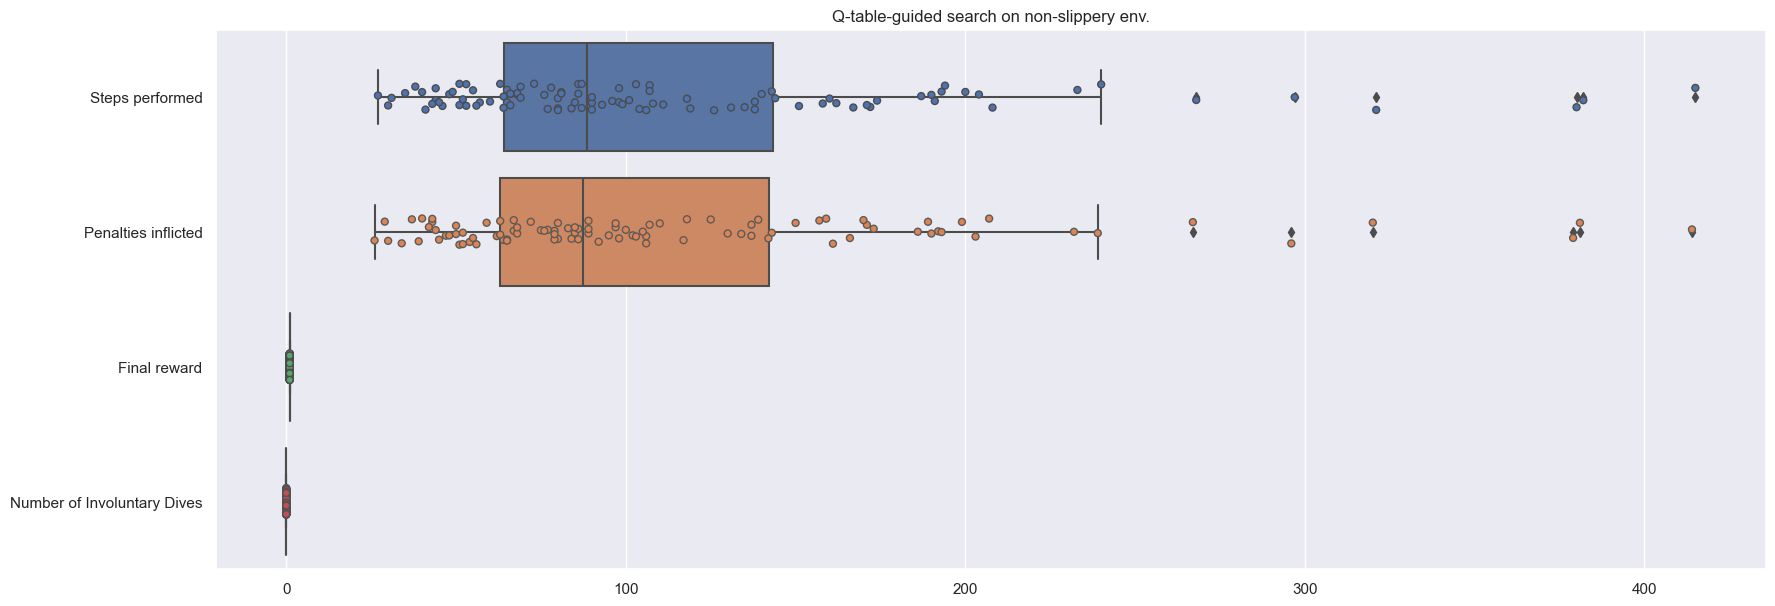

In [226]:
# Visualize aggregated results of the Q-table guided search procedure.
fig, ax = plt.subplots(figsize=(20, 7))
sns.boxplot(data=collected_experiment_info, ax=ax, orient='h')
sns.stripplot(data=collected_experiment_info, ax=ax, orient='h', linewidth=1).set_title('Q-table-guided search on non-slippery env.')
plt.show()

In comparison to the random search method, the q learning method does reach the goal state in less amount of steps (14) and fewer penalties (13).

<div class="alert alert-warning">
    <b>Exercise 3.5 [10 Points]</b>
    <ul>
        <li>Repeat the <i>$Q$-table guided search experiment</i> using $100$ repetitions and the random seed set to $23$. This time we would like to compare both policies (learned for the slippery and non-slippery environment) on the slippery environment. Hence, you have to apply the non-slippery $Q$-table to the slippery environment and also the slippery $Q$-table to the same environment. Remember to reset the seed.</li>
        <li>Compare the number of performed steps as well as the performed dives for both policy results using appropirate visualizations (e.g., box and strip plots). Discuss your observations.</li>
    </ul>
</div>

In [216]:
# Apply the learned non-slippery policy to the slippery env.
env_frozen_lake_q3 = FrozenLakeEnv(slippery = True)
u6.set_environment_seed(environment=env_frozen_lake_q3, seed=23)
num_steps_total, num_involuntary_dives_total, num_penalties_total, final_reward_total = [], [], [], []
num_repetitions = 100

# Collect information over multiple repetitions.
for repetition in range(num_repetitions):
    env_frozen_lake_q3.reset()
    num_steps, num_dives, num_penalties, final_reward = apply_q_table(environment=env_frozen_lake_q3, q_table=q_table_adapted_2)
    num_steps_total.append(num_steps)
    num_involuntary_dives_total.append(num_dives)
    num_penalties_total.append(num_penalties)
    final_reward_total.append(final_reward)

# Combine collected information to a data frame for further downstream analysis.
collected_experiment_info = pd.DataFrame({
    'Steps performed': num_steps_total,
    'Penalties inflicted': num_penalties_total,
    'Final reward': final_reward_total,
    'Number of Involuntary Dives': num_involuntary_dives_total})

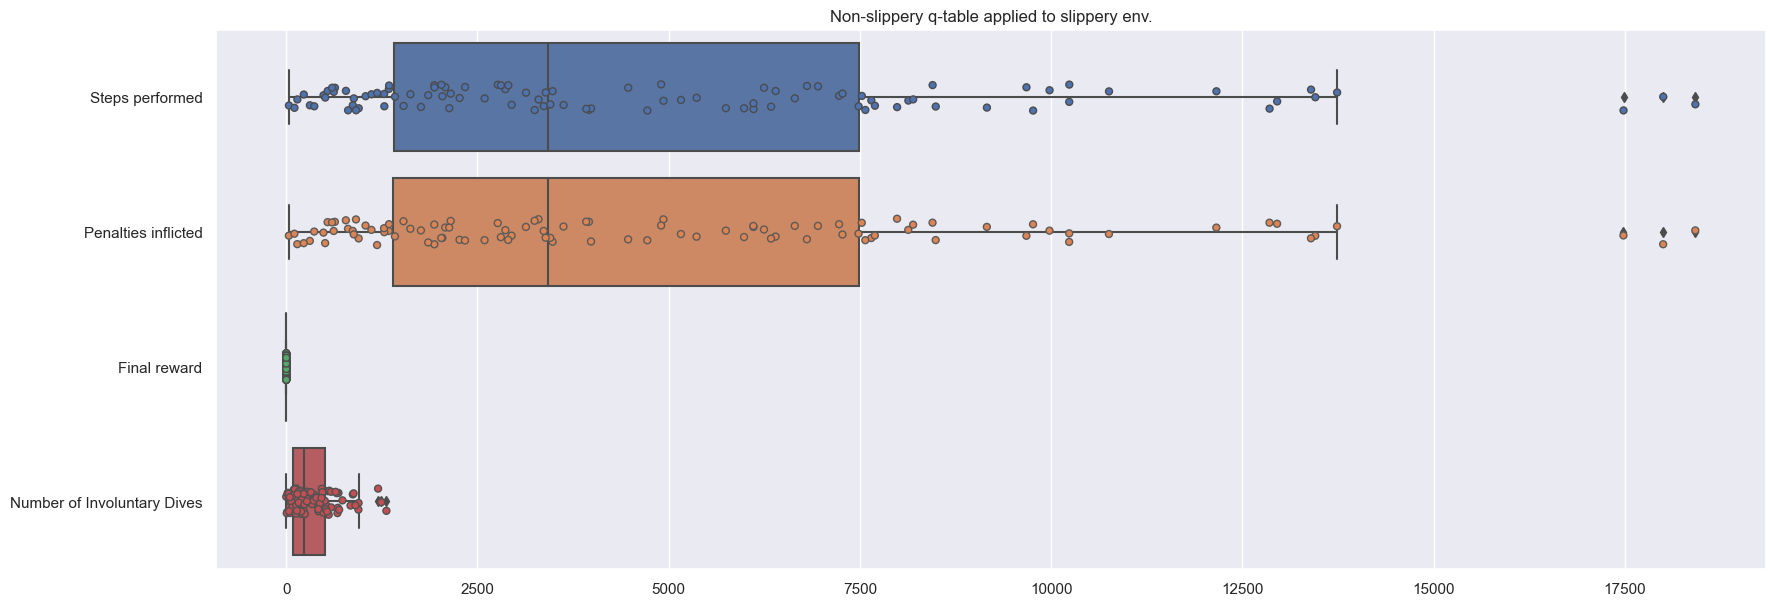

In [219]:
# Visualize aggregated results of the Q-table guided search procedure.
fig, ax = plt.subplots(figsize=(20, 7))
sns.boxplot(data=collected_experiment_info, ax=ax, orient='h')
sns.stripplot(data=collected_experiment_info, ax=ax, orient='h', linewidth=1).set_title('Non-slippery q-table applied to slippery env.')
plt.show()

In [220]:
# Apply the learned slippery policy to the slippery env.
env_frozen_lake_q3 = FrozenLakeEnv(slippery = True)
u6.set_environment_seed(environment=env_frozen_lake_q3, seed=23)
num_steps_total, num_involuntary_dives_total, num_penalties_total, final_reward_total = [], [], [], []
num_repetitions = 100

# Collect information over multiple repetitions.
for repetition in range(num_repetitions):
    env_frozen_lake_q3.reset()
    num_steps, num_dives, num_penalties, final_reward = apply_q_table(environment=env_frozen_lake_q3, q_table=q_table_adapted_3)
    num_steps_total.append(num_steps)
    num_involuntary_dives_total.append(num_dives)
    num_penalties_total.append(num_penalties)
    final_reward_total.append(final_reward)

# Combine collected information to a data frame for further downstream analysis.
collected_experiment_info = pd.DataFrame({
    'Steps performed': num_steps_total,
    'Penalties inflicted': num_penalties_total,
    'Final reward': final_reward_total,
    'Number of Involuntary Dives': num_involuntary_dives_total})

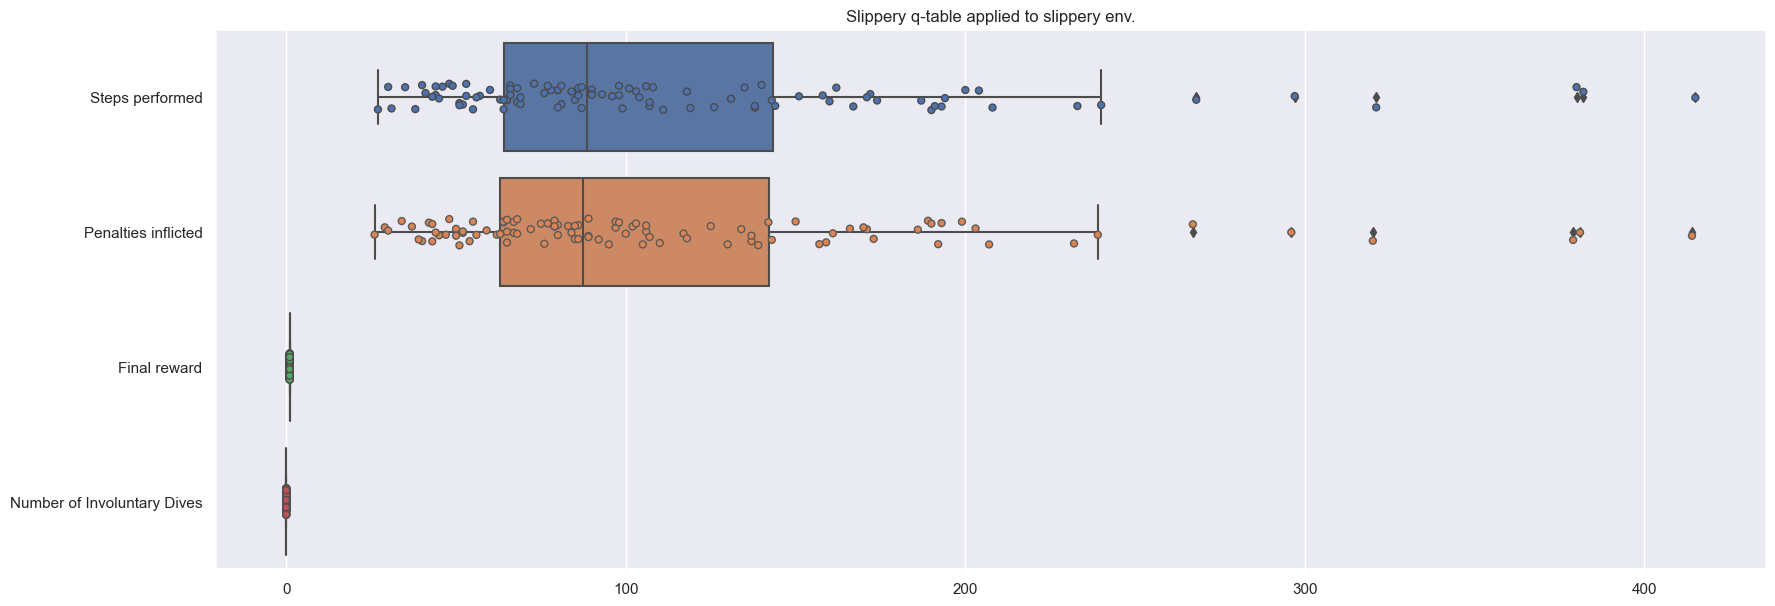

In [221]:
# Visualize aggregated results of the Q-table guided search procedure.
fig, ax = plt.subplots(figsize=(20, 7))
sns.boxplot(data=collected_experiment_info, ax=ax, orient='h')
sns.stripplot(data=collected_experiment_info, ax=ax, orient='h', linewidth=1).set_title('Slippery q-table applied to slippery env.')
plt.show()

The non-slippery policy for the slippery environment takes too long to perform in comparison to the slippery policy (7500 vs. 150)

Similarly, the non-slippery policy inflicts more penalties in comparison to the slippery-policy.

In both cases, the agent does not reach the goal after 100 repetitions.

The agent does not fall into holes with the slippery q-table;  with the non-slippery q-table the agent takes involuntary dives increase towards 1000.

<div class="alert alert-warning">
    <b>Exercise 3.6 [5 Points]</b>
    <ul>
        <li>Assume that you are given new non-slippery <i>FrozenLake</i> environments where holes and frozen tiles are completely randomized (the grid size, start and goal position are the same). How would your learned non-slippery policy from above perform?</li>
    </ul>
</div>

As long as the agent ignores where the holes are, the same policy (for that matter, any policy that is able to move towards the down-right side of the environment could be optimal) would still perform optimally in randomly generated environments.